# Neuroevoluce

Pomocí evolučních algoritmů můžeme vyvíjet i celé neuronové sítě. Buď můžeme evolvovat váhy mezi neurony, strukturu sítě nebo obojí najednou. Nejprve se podíváme, jak naimplementovat jednoduchý algoritmus pro evoluci vah, následně si zkusíme i evoluci vah a struktury sítě najednou pomocí algoritmu NEAT.

## Evoluce vah

Evoluce vah je jednoduchá, stačí naimplementovat jednoduchou neuronovou síť, které umíme nastavit parametry. Náš jedinec v evoluci bude potom jeden dlouhý vektor, který bude reprezentovat váhy mezi vrstvami v neuronové síti. Při vyhodnocování tedy nastavíme síti váhy podle daného jedince a spočítáme její výstup. Zkusíme si tímto způsobem implementovat klasifikaci na našem oblíbeném datasetu iris.

In [1]:
from sklearn import datasets, model_selection
import numpy as np
import collections
from deap import algorithms, creator, base, benchmarks, cma, tools

Začneme tím, že si připravíme jednoduchou implementaci neuronové sítě. Při inicializaci nastavíme vrstvy, jejich velikosti a také jejich aktivace, jelikož každá vrstva může mít svou vlastní aktivační funkci. Dále budeme potřebovat jednoho dlouhého linárního jedince všech vah rozdělit na váhové matice. To uděláme tak, že budeme brát vždy velikost akutální vrstvy a velikost té následující a na základě toho vezmeme odpovídající část jedince a z něj vytvoříme matici vah. Zároveň musíme přidat biasy, takže velikost aktuální vrstvy zvětšíme ještě o 1. Nakonec bude potřeba ještě funkce pro evaluaci sítě, která vytvořenou síť vyhodnotí tak, že pro každou vrstvu použije odpovídající aktivaci a vrátí nám výstup sítě.

In [2]:
class NeuralNetwork: 
    def __init__(self, layer_sizes, activations):
        self.layer_sizes = layer_sizes
        self.layers = None

        # kontrola, zda pocet akivaci sedi na pocet vrstev
        if len(list(activations)) != len(layer_sizes) - 1:
            raise AttributeError("Number of activations does not match number of layers")
        
        self.activations = list(activations)
        self.vectorized_net = None

    # vraci velikosti vahovych matic mezi vrstvami
    def vectorized_size(self):
        return sum(map(lambda x: (x[0] + 1) * x[1], zip(self.layer_sizes, self.layer_sizes[1:])))

    # vezme sit a nastavi hodnoty vahovych matic podle jedince 
    def set_weights(self, vectorized_net):
        
        # kontrola, zda si velikosti odpovidaji
        if len(vectorized_net) != self.vectorized_size():
            raise AttributeError(
                f"Length of vector does not match vectorized_size: {len(vectorized_net)} != {self.vectorized_size()}")

        self.vectorized_net = vectorized_net
        self.layers = []
        sum_sizes = 0
        
        # prochazim vrstvy a beru vzdy aktualni a 1 nasledujici a vyrabim vahove matice tim ze vybiram spravnou cast jedince
        for (p, n) in zip(self.layer_sizes, self.layer_sizes[1:]):
            layer = vectorized_net[sum_sizes: sum_sizes + (p + 1) * n]
            self.layers.append(np.reshape(layer, newshape=(p + 1, n))) # reshape do spravneho tvaru
            sum_sizes += (p + 1) * n # soucet velikosti predchozich vrstev pro indexaci


    # vyhodnoceni site
    def eval_network(self, inputs):
        activations = inputs
        
        for act_func, layer in zip(self.activations, self.layers):
            activations_1 = np.append(np.array([1.0]), activations)  # rozsireni matice vah o konstantu 1.0 pro biasy
            activations = act_func(np.dot(activations_1, layer))

        return activations

Nyní si akorát načteme data a rozdělíme si je na trénovací a testovací.

In [3]:
iris = datasets.load_iris()
train_x, test_x, train_y, test_y = model_selection.train_test_split(iris.data, iris.target)

Musíme si ještě definovat fitness funkci, což bude pouze vyhodnocení sítě na datech, kdy vždy vybereme predikovanou třídu s maximální pravděpodobností a spočítáme pak celkovou accuracy. Zároveň si definujeme vlastní lineární a relu aktivace.

In [4]:
def relu(x):
    return np.maximum(0,x)

def linear(x):
    return x

def fitness(ind, X, y):
    net.set_weights(ind)
    
    acc = 0
    for xi, yi in zip(X, y):
        if np.argmax(net.eval_network(xi)) == yi:
            acc += 1
    
    return acc/len(y),

Pro samotné nastavení vah neuronové sítě použíjeme algoritmus CMA-ES, což je evoluční strategie, která je dobrá na úlohy spojité optimalizace, kterou máme i zde. V evoluční strategii se nevyskytuje křížení, ale místo něj se klade důraz na mutaci. Zde se používá námi známá gaussovská mutace. Evoluční strategii používáme také proto, že nám umožňuje váhy měnit korelovaně, protože si pamatuje celou kovariační matici, ze které generuje jedince. Klasická evoluce umí měnit váhy jen nezávisle na sobě, a dává proto horší výsledky. CMA-ES je implementována v knihovně deap, a je tedy snadné ji použít.

In [5]:
net = NeuralNetwork([4, 5, 3], [relu, linear])
ind_size = net.vectorized_size()    
    
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("evaluate", fitness, X=train_x, y=train_y)

strategy = cma.Strategy(centroid=[0.0]*ind_size, sigma=0.1, lambda_=5*ind_size)
toolbox.register("generate", strategy.generate, creator.Individual)
toolbox.register("update", strategy.update)

hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

_ = algorithms.eaGenerateUpdate(toolbox, ngen=250, stats=stats, halloffame=hof)

gen	nevals	avg     	std      	min	max     
0  	215   	0.333056	0.0761942	0  	0.660714
1  	215   	0.341321	0.084062 	0  	0.6875  
2  	215   	0.34539 	0.0851503	0  	0.651786
3  	215   	0.339909	0.0981217	0  	0.660714
4  	215   	0.352367	0.087026 	0  	0.678571
5  	215   	0.354817	0.113475 	0  	0.651786
6  	215   	0.358638	0.0959204	0  	0.651786
7  	215   	0.352284	0.0880549	0  	0.651786
8  	215   	0.342982	0.0983937	0  	0.660714
9  	215   	0.364992	0.0991907	0  	0.901786
10 	215   	0.373588	0.109265 	0  	0.732143
11 	215   	0.372757	0.118714 	0  	0.9375  
12 	215   	0.402243	0.130592 	0  	0.732143
13 	215   	0.38941 	0.121007 	0  	0.732143
14 	215   	0.404693	0.131298 	0.0267857	0.875   
15 	215   	0.426038	0.141188 	0.00892857	0.928571
16 	215   	0.417234	0.14817  	0.0267857 	0.8125  
17 	215   	0.451537	0.159281 	0.0178571 	0.964286
18 	215   	0.454111	0.149284 	0.0625    	0.848214
19 	215   	0.466445	0.157425 	0.0803571 	0.946429
20 	215   	0.451786	0.156962 	0         	0.821429
21 	21

165	215   	0.989659	0.00397545	0.973214  	0.991071
166	215   	0.990407	0.0033799 	0.955357  	0.991071
167	215   	0.990116	0.00325302	0.973214  	0.991071
168	215   	0.990365	0.00383457	0.946429  	0.991071
169	215   	0.990449	0.00321944	0.955357  	0.991071
170	215   	0.990324	0.00325036	0.973214  	0.991071
171	215   	0.990449	0.0025801 	0.973214  	0.991071
172	215   	0.990282	0.0030641 	0.973214  	0.991071
173	215   	0.99049 	0.0026604 	0.973214  	0.991071
174	215   	0.990365	0.00255862	0.973214  	0.991071
175	215   	0.990822	0.00147059	0.982143  	0.991071
176	215   	0.990739	0.00189671	0.973214  	0.991071
177	215   	0.991071	1.11022e-16	0.991071  	0.991071
178	215   	0.990864	0.00159762 	0.973214  	0.991071
179	215   	0.990988	0.000857133	0.982143  	0.991071
180	215   	0.990988	0.000857133	0.982143  	0.991071
181	215   	0.990905	0.00148227 	0.973214  	0.991071
182	215   	0.990988	0.000857133	0.982143  	0.991071
183	215   	0.991071	1.11022e-16	0.991071  	0.991071
184	215   	0.990988	0.00

Na závěr si zkusíme otestovat síť na testovacích datech a změřit na nich accuracy.

In [7]:
fitness(hof[0], test_x, test_y)

(0.9736842105263158,)

## NEAT

Zkusíme se podívat na algoritmus NEAT na příkladu s datasetem iris a zkusíme pro něj najít nejvhodnější síť, která bude umět data nejlépe klasifikovat. Samotná implementace algorimtu není vůbec jednoduchá, ale naštěstí v pythonu existuje knihovna neat-python, kde už tu práci někdo udělal za nás. Knihovna má trochu jiný interface, než na co jsme zvyklí, ale není složité se jí naučit používat. Nastavení parametrů algoritmu se načítá ze zvláštního souboru *config-feedforward*. Dokumentace k jeho formátování se nachází [zde](https://neat-python.readthedocs.io/en/latest/config_file.html). Potom už stačí jen algoritmus spustit. Níže uvedený příklad vychází z dokumentace k [neat-python](https://github.com/CodeReclaimers/neat-python/tree/master/examples/xor) upravený pro naši klasifikaci irisů.


 ****** Running generation 0 ****** 

Population's average fitness: 36.37333 stdev: 13.03613
Best fitness: 73.00000 - size: (3, 12) - species 1 - id 81
Average adjusted fitness: 0.498
Mean genetic distance 1.174, standard deviation 0.242
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   150     73.0    0.498     0
Total extinctions: 0
Generation time: 0.738 sec

 ****** Running generation 1 ****** 

Population's average fitness: 40.01333 stdev: 11.95937
Best fitness: 73.00000 - size: (3, 12) - species 1 - id 81
Average adjusted fitness: 0.542
Mean genetic distance 1.360, standard deviation 0.255
Population of 150 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   150     73.0    0.542     1
Total extinctions: 0
Generation time: 0.735 sec (0.736 average)

 ****** Running generation 2 ****** 

Population's average fitness: 41.21333 

Population's average fitness: 51.77333 stdev: 18.34054
Best fitness: 108.00000 - size: (3, 7) - species 2 - id 1912
Average adjusted fitness: 0.265
Mean genetic distance 2.039, standard deviation 0.527
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   18    81    103.0    0.280     6
     2    2    69    108.0    0.250     1
Total extinctions: 0
Generation time: 0.642 sec (0.664 average)

 ****** Running generation 19 ****** 

Population's average fitness: 54.97333 stdev: 19.09344
Best fitness: 108.00000 - size: (3, 7) - species 2 - id 1912
Average adjusted fitness: 0.346
Mean genetic distance 2.021, standard deviation 0.561
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   19    57    103.0    0.344     7
     2    3    93    108.0    0.347     2
Total extinctions: 0
Generation time: 0.670 sec (0.663 average)

 ****** Run

Population's average fitness: 58.11258 stdev: 19.33516
Best fitness: 108.00000 - size: (3, 4) - species 1 - id 4776
Average adjusted fitness: 0.348
Mean genetic distance 1.965, standard deviation 0.607
Population of 151 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   33    49    108.0    0.316    21
     2   17    47    107.0    0.385    16
     3   12    55    108.0    0.343    10
Total extinctions: 0
Generation time: 0.596 sec (0.598 average)

 ****** Running generation 34 ****** 

Population's average fitness: 57.58278 stdev: 20.68635
Best fitness: 108.00000 - size: (3, 4) - species 1 - id 4776
Average adjusted fitness: 0.338
Mean genetic distance 1.975, standard deviation 0.594
Population of 151 members in 3 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   34    60    108.0    0.379    22
     2   18    30    107.0    0.340    17
     3   13    61    108.0    0.29

Population's average fitness: 58.53333 stdev: 20.01522
Best fitness: 109.00000 - size: (3, 4) - species 1 - id 6393
Average adjusted fitness: 0.347
Mean genetic distance 1.910, standard deviation 0.623
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   49    71    109.0    0.368    14
     3   28    79    108.0    0.327    26
Total extinctions: 0
Generation time: 0.561 sec (0.572 average)

 ****** Running generation 50 ****** 

Population's average fitness: 55.40667 stdev: 20.68304
Best fitness: 109.00000 - size: (3, 4) - species 1 - id 6393
Average adjusted fitness: 0.308
Mean genetic distance 1.915, standard deviation 0.665
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   50    78    109.0    0.378    15
     3   29    72    108.0    0.237    27
Total extinctions: 0
Generation time: 0.555 sec (0.572 average)

 ****** Run

Population's average fitness: 56.51333 stdev: 21.51673
Best fitness: 109.00000 - size: (3, 4) - species 1 - id 6393
Average adjusted fitness: 0.518
Mean genetic distance 1.994, standard deviation 0.637
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   65    57    109.0    0.513    30
     3   44    93    108.0    0.524    42
Total extinctions: 0
Generation time: 0.718 sec (0.630 average)

 ****** Running generation 66 ****** 

Population's average fitness: 57.91333 stdev: 20.67299
Best fitness: 109.00000 - size: (3, 4) - species 1 - id 6393
Average adjusted fitness: 0.337
Mean genetic distance 1.884, standard deviation 0.582
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   66    55    109.0    0.337    31
     3   45    95    108.0    0.336    43
Total extinctions: 0
Generation time: 0.629 sec (0.633 average)

 ****** Run

Population's average fitness: 56.01333 stdev: 21.31603
Best fitness: 110.00000 - size: (4, 7) - species 1 - id 10640
Average adjusted fitness: 0.306
Mean genetic distance 2.098, standard deviation 0.579
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   81    70    110.0    0.359     9
     3   60    80    108.0    0.252    58
Total extinctions: 0
Generation time: 0.679 sec (0.620 average)

 ****** Running generation 82 ****** 

Population's average fitness: 62.23333 stdev: 19.71579
Best fitness: 110.00000 - size: (4, 7) - species 1 - id 10640
Average adjusted fitness: 0.498
Mean genetic distance 2.059, standard deviation 0.600
Population of 150 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   82    76    110.0    0.514    10
     3   61    74    108.0    0.483    59
Total extinctions: 0
Generation time: 0.794 sec (0.642 average)

 ****** R

Population's average fitness: 62.39333 stdev: 21.38096
Best fitness: 110.00000 - size: (4, 6) - species 1 - id 12093
Average adjusted fitness: 0.394
Mean genetic distance 2.437, standard deviation 0.642
Population of 149 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   96    37    110.0    0.397    24
     4   12    33    107.0    0.403     6
     5    5    44    110.0    0.351     4
     6    2    35    105.0    0.426     0
Total extinctions: 0
Generation time: 0.605 sec (0.655 average)

 ****** Running generation 97 ****** 

Population's average fitness: 59.36242 stdev: 22.67252
Best fitness: 110.00000 - size: (4, 6) - species 1 - id 12093
Average adjusted fitness: 0.353
Mean genetic distance 2.478, standard deviation 0.668
Population of 149 members in 4 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   97    33    110.0    0.359    25
     4   13    36    107.0    0.

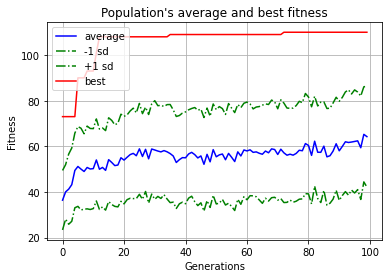

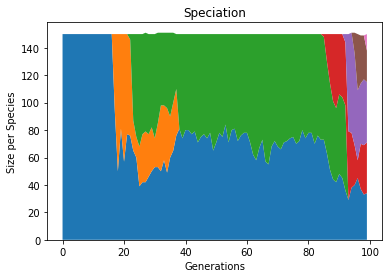

In [10]:
import neat
import visualize
import os

# pokud vam to pada s errorem, je potreba nastavit spravne cestu ke graphviz
#os.environ["PATH"] += os.pathsep + 'C:/Users/katie/Anaconda3/Library/bin/graphviz'

# vytvoreni a vyhodnoceni site v neatu - fitness funkce
def eval_genomes(genomes, config):
    for genome_id, genome in genomes:
        genome.fitness = 0.0
        net = neat.nn.FeedForwardNetwork.create(genome, config) 
        for xi, xo in zip(train_x, train_y): 
            output = net.activate(xi)
            if np.argmax(output) == xo:
                genome.fitness += 1

def run(config_file):
    
    # nacteme konfiguraci neatu 
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)
    # vytvorime novou populaci
    p = neat.Population(config)

    # pridame statisticke vypocty pro logovani evoluce    
    p.add_reporter(neat.StdOutReporter(show_species_detail=True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    
    # pustime pro dany pocet generaci
    winner = p.run(eval_genomes, 100)

    # zobrazime nejlepsiho jedince a jeho vystup
    print('\nBest genome:\n{!s}'.format(winner))
    print('\nOutput:')
    winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
    for xi, xo in zip(train_x, train_y):
        output = winner_net.activate(xi)
        print("input {!r}, expected output {!r}, got {!r}".format(xi, xo, output))

    # vykresluje nejlepsi sit
    node_names = {-1:'x1', -2: 'x2', -3: 'x3', -4: 'x4', 0:'setosa', 1:'virginica', 2:'versicolor'}
    visualize.draw_net(config, winner, True, node_names=node_names) 
    visualize.plot_stats(stats, ylog=False, view=True)
    visualize.plot_species(stats, view=True)

    #p = neat.Checkpointer.restore_checkpoint('neat-checkpoint-4')
    #p.run(eval_genomes, 10)

if __name__ == '__main__':
    # urceni cesty ke konfiguracnimu souboru
    config_path = os.path.join('.', 'config-feedforward')
    run(config_path)

## Úkol na cvičení

Zkuste si pohrát s NEATem a vyskoušet si ho třeba na OpenAI Gym, který jsme dělali na druhém cvičení. Bude potřeba upravit  fitness funkci, tedy místo accuracy dát odměnu za hru a také bude potřeba změnit pár věcí v konfiguračním souborum například parametry počáteční sítě a podmínky, kdy má algoritmus skončit. [Zde](https://github.com/CodeReclaimers/neat-python/tree/master/examples/openai-lander) je pro inspiraci vyřešený [LunarLander](https://gym.openai.com/envs/LunarLander-v2/). Můžete si vybrat libovolný z [problémů](https://gym.openai.com/envs/#classic_control) z knihovny gym a zkusit vytvořit a natrénovat neuronovou síť pomocí neuroevoluce. 
